In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [33]:
# Yolo 로드
net = cv2.dnn.readNetFromDarknet("/Users/reejungkim/Documents/Git/ImgProcessor/YOLO/yolov2-tiny.cfg", 
                                 "/Users/reejungkim/Documents/Git/ImgProcessor/YOLO/yolov2-tiny.weights")
classes = []
with open("/Users/reejungkim/Documents/Git/ImgProcessor/YOLO/yolo.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
#output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))


In [34]:
colors

array([[146.97258126,  18.66572455, 119.04422314],
       [199.4387983 ,  28.83212525, 161.60995679],
       [ 96.8793153 , 132.35637065, 166.36786679],
       [146.39949497, 132.73785235,  60.32047681],
       [211.73908415, 171.98023482, 102.92409451],
       [212.74422486, 176.14648723, 175.00901978],
       [  0.70482413, 184.84026592, 252.96072106],
       [160.33068459, 149.23587111,  60.52462569],
       [119.69544994, 196.19874592,  53.76430836],
       [118.90909923, 250.2025383 , 166.35930035],
       [222.24975477,  77.86077128, 171.67713471],
       [ 65.8823596 , 163.35330761, 240.41501186],
       [ 89.56552035,  28.01884152, 156.72122346],
       [103.0316332 , 117.20290405,  30.94440248],
       [209.99162258, 213.52334389, 254.77207487],
       [113.02393104,  93.491236  , 128.4358163 ],
       [180.99286626,  45.30182144, 229.62507981],
       [252.94290219,  62.60170185, 183.73929754],
       [138.41002222,  16.42262685, 144.50338076],
       [188.32335918,  51.99087

In [24]:
def get_detected_img(cv_net, img_array, conf_threshold, nms_threshold, use_copied_array=True, is_print=True):
    
    # 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함. 
    # 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    #전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
    layer_names = cv_net.getLayerNames()
    outlayer_names = [layer_names[i[0] - 1] for i in cv_net.getUnconnectedOutLayers()]
    
    # 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))
    start = time.time()
    # Object Detection 수행하여 결과를 cvOut으로 반환 
    cv_outs = cv_net.forward(outlayer_names)
    layerOutputs = cv_net.forward(outlayer_names)
    # bounding box의 테두리와 caption 글자색 지정
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    class_ids = []
    confidences = []
    boxes = []

    # 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화 
    for ix, output in enumerate(cv_outs):
        # Detected된 Object별 iteration
        for jx, detection in enumerate(output):
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            # confidence가 지정된 conf_threshold보다 작은 값은 제외 
            if confidence > conf_threshold:
                #print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)
                # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
                # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
                center_x = int(detection[0] * cols)
                center_y = int(detection[1] * rows)
                width = int(detection[2] * cols)
                height = int(detection[3] * rows)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
    
    # NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    if len(idxs) > 0:
        for i in idxs.flatten():
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)

    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")
    return draw_img

image shape: (786, 800, 3)


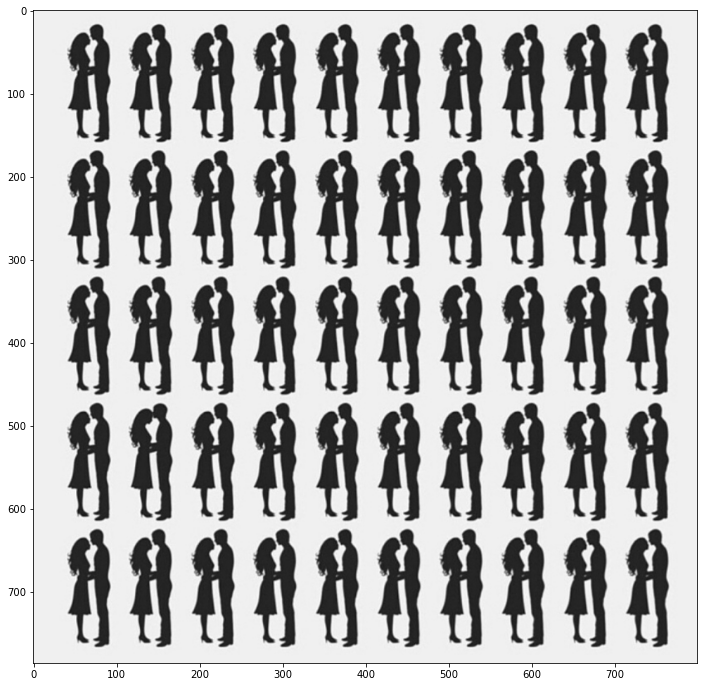

In [29]:
img = cv2.imread('/Users/reejungkim/Documents/Git/ImgProcessor/img/objects.jpeg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [31]:
cv_net_yolo  = cv2.dnn.readNetFromDarknet("/Users/reejungkim/Documents/Git/ImgProcessor/YOLO/yolov2-tiny.cfg", 
                                 "/Users/reejungkim/Documents/Git/ImgProcessor/YOLO/yolov2-tiny.weights")

#tiny yolo의 경우 confidence가 일반적으로 낮음. 
conf_threshold = 0.3
nms_threshold = 0.4
# Object Detetion 수행 후 시각화 
draw_img = get_detected_img(cv_net_yolo, img, 
                            conf_threshold=conf_threshold, 
                            nms_threshold=nms_threshold, 
                            use_copied_array=True, 
                            is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

IndexError: invalid index to scalar variable.